In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from copy import deepcopy

from qiskit import IBMQ, pulse, schedule, transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.pulse import pulse_lib as pulse_library, reschedule
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
import qiskit.ignis.mitigation.measurement as mit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.basis import PauliBasis
from qiskit.visualization.state_visualization import plot_state_city
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Gate
from qiskit.scheduler import schedule_circuit, ScheduleConfig
from qiskit.quantum_info import state_fidelity, process_fidelity

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()
props = backend.properties()

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


## XGate Process Tomography

We study the fidelity of an X process, implemented through an odd number of repetitions of the X gate.
The X gate is done with 2 pulses (a standard U3 implementation), or 1 pulse (an optimized implementation).

### experiment parameters

In [6]:
def qubit_t1(qubit):
    return props.qubits[qubit][0].value

def qubit_t2(qubit):
    return props.qubits[qubit][1].value

def sort_qubits_by_t1():
    """in ascending order"""
    qubits = [i for i in range(config.n_qubits)]
    qubits = sorted(qubits, key=qubit_t1)
    return qubits

In [7]:
sort_qubits_by_t1()

[7, 15, 11, 2, 10, 8, 16, 1, 6, 12, 17, 19, 13, 18, 3, 4, 5, 0, 14, 9]

In [8]:
qubit = sort_qubits_by_t1()[0]  # which qubit to study
reps = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]  # how many repetitions of the x gate
shots = 1000

### set up process tomography

In [9]:
def qpt_circuits_and_schedules(schedule):
    """
    create the process tomography circuits
    create a new 'repx' gate which will we later add to the cmd_def
    """
    num_qubits = 1
    qr = QuantumRegister(num_qubits)
    my_gate = Gate(name='repx', num_qubits=num_qubits, params=[])

    # create the tomography circuits
    qc = QuantumCircuit(qr)
    qc.append(my_gate, qr[:])
    qpt_circuits = process_tomography_circuits(qc, measured_qubits=qr)

    # transpile so that the singles are in terms of the u gates
    qpt_circuits = transpile(qpt_circuits, backend, initial_layout=[qubit], basis_gates=['u1','u2','u3','repx'])

    # add the custom gate to the cmd def
    cmd_def.add("repx", qubits=[qubit], schedule=schedule)

    # schedule!
    schedule_config = ScheduleConfig(cmd_def, meas_map=backend.configuration().meas_map)
    qpt_schedules = [schedule_circuit(circ, schedule_config) for circ in qpt_circuits]
    
    return qpt_circuits, qpt_schedules

In [10]:
circuits_std = []
schedules_std = []
circuits_opt = []
schedules_opt = []

In [11]:
# Standard X gate (U3(pi, 0, pi))
for rep in reps:
    schedule_std = q.pulse.Schedule()
    x_sched = cmd_def.get('u3', qubits=[qubit], P0=np.pi, P1=0, P2=np.pi)
    for _ in range(rep):
        schedule_std |= x_sched << schedule_std.duration
    
    qpt_circuits_std, qpt_schedules_std = qpt_circuits_and_schedules(schedule_std)
    circuits_std.append(qpt_circuits_std)
    schedules_std.append(qpt_schedules_std)

In [12]:
# Direct X gate
for rep in reps:
    schedule_opt = q.pulse.Schedule()
    x_sched = cmd_def.get('x', qubits=[qubit])
    for _ in range(rep):
        schedule_opt |= x_sched << schedule_opt.duration
    
    qpt_circuits_opt, qpt_schedules_opt = qpt_circuits_and_schedules(schedule_opt)
    circuits_opt.append(qpt_circuits_opt)
    schedules_opt.append(qpt_schedules_opt)

In [13]:
import itertools
flat_schedules_std = list(itertools.chain(*schedules_std))
flat_schedules_opt = list(itertools.chain(*schedules_opt))

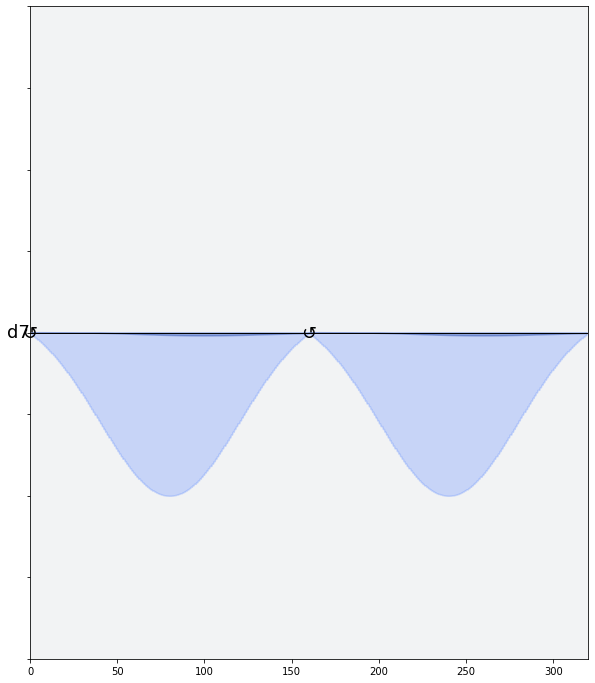

In [14]:
# sanity check schedules
schedules_std[0][2].draw(channels=[config.drive(qubit)], table=False)

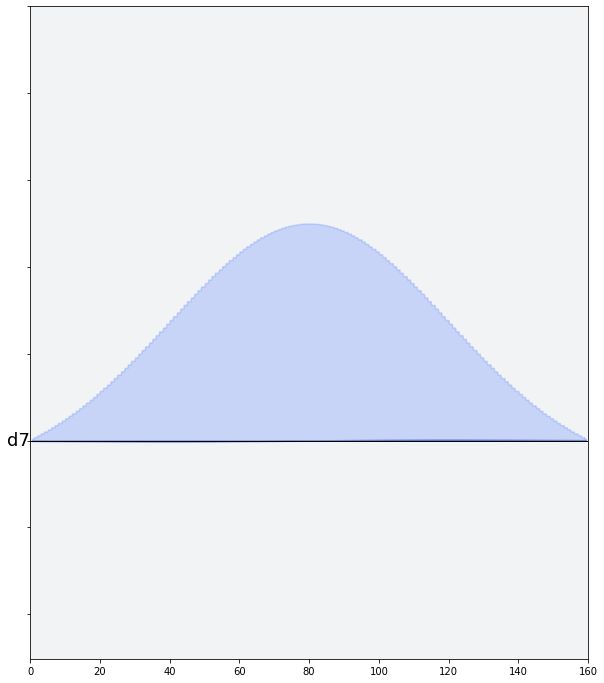

In [15]:
schedules_opt[0][2].draw(channels=[config.drive(qubit)], table=False)

### Run readout mitigation cals

In [16]:
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0])
job_mit = q.execute(meas_qcs, backend, initial_layout=[qubit])

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [17]:
job_mit.status()

<JobStatus.VALIDATING: 'job is being validated'>

### Coherence limit error
What is the best error we can hope for from the gates?

In [18]:
from qiskit.ignis.verification.randomized_benchmarking.rb_utils import coherence_limit

t1 = qubit_t1(qubit)
t2 = qubit_t2(qubit)

durations_std = []
durations_opt = []
max_fidelities_std = []
max_fidelities_opt = []

for i, rep in enumerate(reps):
    u3_duration = schedules_std[i][2].ch_duration(config.drive(qubit))*config.dt*1e6  # in us
    u3_error_limit = coherence_limit(nQ=1, T1_list=[t1], T2_list=[t2], gatelen=u3_duration)

    x_duration = schedules_opt[i][2].ch_duration(config.drive(qubit))*config.dt*1e6  # in us
    x_error_limit = coherence_limit(nQ=1, T1_list=[t1], T2_list=[t2], gatelen=x_duration)
    
    durations_std.append(u3_duration*1000)
    durations_opt.append(x_duration*1000)
    max_fidelities_std.append(1 - u3_error_limit)
    max_fidelities_opt.append(1- x_error_limit)
    
print(max_fidelities_std)
print(max_fidelities_opt)

[0.9986713336829338, 0.9960247918637533, 0.9933925718144425, 0.9907745947413762, 0.9881707822903484, 0.9855810565440963, 0.9830053400198364, 0.9804435556668151, 0.977895626863874, 0.975361477417028, 0.9728410315570579]
[0.9993352161899399, 0.9980083512365956, 0.9966850815650563, 0.9953653972709093, 0.9940492884774, 0.9927367453353547, 0.9914277580231017, 0.9901223167463945, 0.9888204117383337, 0.9875220332592902, 0.9862271715968285]


### Experimental error
Get fidelity of execution.

In [19]:
job_std = q.execute(flat_schedules_std, backend)
job_opt = q.execute(flat_schedules_opt, backend)

In [26]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

In [28]:
job_std.status()

<JobStatus.DONE: 'job has successfully run'>

In [30]:
job_opt.status()

<JobStatus.DONE: 'job has successfully run'>

In [31]:
result_std = job_std.result()
result_opt = job_opt.result()
result_mit = job_mit.result()

In [32]:
from qiskit.result import marginal_counts
# mitigate results
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels, qubit_list=[qubit])

# marginalize to ignore non-interesting qubits that needed to be measured due to pulse control
result_std_marg = marginal_counts(result_std, [qubit])
result_opt_marg = marginal_counts(result_opt, [qubit])

#result_std_mit = readout_fitter.filter.apply(result_std_marg)
#result_opt_mit = readout_fitter.filter.apply(result_opt_marg)

In [33]:
# get ideal process
from qiskit.quantum_info import Operator
from qiskit.extensions.standard import XGate
from qiskit.tools.qi.qi import outer
ideal_unitary = Operator(XGate()).data
choi_ideal = outer(ideal_unitary.ravel(order='F'))

In [34]:
from copy import deepcopy
result_cpy_std = deepcopy(result_std_marg)
result_cpy_opt = deepcopy(result_opt_marg)

In [38]:
fidelities_std = []
fidelities_opt = []
for i, rep in enumerate(reps):
    result_std_mit = readout_fitter.filter.apply(result_cpy_std)
    result_opt_mit = readout_fitter.filter.apply(result_cpy_opt)
    
    # remove results for other rep
    # TODO: allow selecting subset of result
    single_qpt_size = len(circuits_std[0])
    del result_std_mit.results[:i*single_qpt_size]
    del result_std_mit.results[single_qpt_size:]
    del result_opt_mit.results[:i*single_qpt_size]
    del result_opt_mit.results[single_qpt_size:]
    assert len(result_std_mit.results) == len(circuits_std[i])
    assert len(result_opt_mit.results) == len(circuits_std[i])

    qpt_fitter = ProcessTomographyFitter(result_std_mit, circuits_std[i])
    choi_cvx = qpt_fitter.fit(method='cvx')
    fidelity = np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False))
    fidelities_std.append(fidelity)

    qpt_fitter = ProcessTomographyFitter(result_opt_mit, circuits_std[i])
    choi_cvx = qpt_fitter.fit(method='cvx')
    fidelity = np.real(process_fidelity(choi_ideal, choi_cvx.data, require_cptp=False))
    fidelities_opt.append(fidelity)

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12


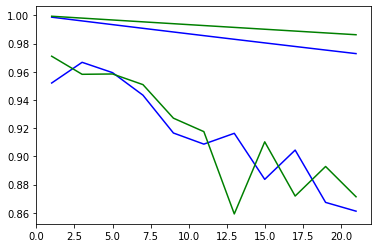

In [40]:
import matplotlib.pyplot as plt
plt.plot(reps, fidelities_std, 'b-')
plt.plot(reps, fidelities_opt, 'g-')
plt.plot(reps, max_fidelities_std, 'b')
plt.plot(reps, max_fidelities_opt, 'g')

## Direct RX(theta) Gate

In [ ]:
# rx(pi/8) gate
circuit = q.QuantumCircuit(1)
# standard rx(pi/8) gate decomposition is U3(pi/8, -pi/2, pi/2)
schedule = cmd_def.get('u3', qubits=[0], P0=np.pi/8, P1=-np.pi/2, P2=np.pi/2)
schedule = q.pulse.SamplePulse([0.1])(config.drive(0)) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[config.drive(0)])

In [ ]:
# Our way
circuit = q.QuantumCircuit(1)
circuit.rx(np.pi/8, 0)
print(circuit)

decomposed_circuit = circuit.decompose()
print(decomposed_circuit)

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
print(transpiled_circuit)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule = q.pulse.SamplePulse([0.1])(config.drive(0)) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[system.qubits[0].drive])

In [ ]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector()